<a href="https://colab.research.google.com/github/gabi-pacheco/MTG-Commander-Analysis/blob/main/Revised_Magic_the_gathering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Magic the Gathering games analysis

The original dataset has a collection of match information regarding Magic the Gathering games between a small group of friends. The game format played is Commander, which allows for multiple players to join each match.

The data offers deck and player information regarding 53 matches played between June 2023 and August 2024.

##Task
Analyse deck and player performance

##Questions

* Which decks have the highest win rate?
* Are there trends in wins over time?
* Are some decks more dominant against specific players or decks?
* How do win types vary between players or decks?
* How many games does each player participate in, and how often do they win?
* How does the type of victory correlate with the deck or player? *


##Initial Exploration

In [1]:
import pandas as pd

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Open the Google Sheets document by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1mFXxnuRiLLEecnRxwJEFD4q1K-yV-hJXt3qpJHGUmPI/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet
worksheet = spreadsheet.get_worksheet(2)

# Get all values from the sheet as a list of lists
rows = worksheet.get_all_values()

# Convert the list of lists to a DataFrame
magic = pd.DataFrame(rows[1:], columns=rows[0])

magic.head()

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype
0,9-6-2023,9418966F,Bruse Tymna,0,Karador,1,Ikra Tymna,0,Athreos,0,Last one standing
1,9-6-2023,474B90FE,Krav Regna,0,Animar,0,Atraxa,1,"Sheodred, the Apocalypse",0,Last one standing
2,9-6-2023,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun
3,9-6-2023,3BB54FCC,"Omnath, Locus of Rage",0,Korvold,0,Breya,1,"Sheodred, the Apocalypse",0,Last one standing
4,17-6-2023,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo


In [4]:
magic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          53 non-null     object
 1   Game_id       53 non-null     object
 2   Jeroen_deck   53 non-null     object
 3   Jeroen_Win    53 non-null     object
 4   Mattijs_deck  53 non-null     object
 5   Mattijs_win   53 non-null     object
 6   Erwin_deck    53 non-null     object
 7   Erwin_win     53 non-null     object
 8   Lucien_deck   53 non-null     object
 9   Lucien_win    53 non-null     object
 10  Wintype       53 non-null     object
dtypes: object(11)
memory usage: 4.7+ KB


##Data Cleaning

Change date format

In [5]:
magic['Date'] = pd.to_datetime(magic['Date'], format='%d-%m-%Y', errors='coerce')
magic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          53 non-null     datetime64[ns]
 1   Game_id       53 non-null     object        
 2   Jeroen_deck   53 non-null     object        
 3   Jeroen_Win    53 non-null     object        
 4   Mattijs_deck  53 non-null     object        
 5   Mattijs_win   53 non-null     object        
 6   Erwin_deck    53 non-null     object        
 7   Erwin_win     53 non-null     object        
 8   Lucien_deck   53 non-null     object        
 9   Lucien_win    53 non-null     object        
 10  Wintype       53 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 4.7+ KB


Normalize text

In [6]:
#normalize Wintype
magic['Wintype'] = magic['Wintype'].str.capitalize()

#normalize decks names
columns_to_normalize = ['Jeroen_deck', 'Mattijs_deck', 'Erwin_deck', 'Lucien_deck']

for column in columns_to_normalize:
    magic[column] = magic[column].str.capitalize()

magic.head()

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype
0,2023-06-09,9418966F,Bruse tymna,0,Karador,1,Ikra tymna,0,Athreos,0,Last one standing
1,2023-06-09,474B90FE,Krav regna,0,Animar,0,Atraxa,1,"Sheodred, the apocalypse",0,Last one standing
2,2023-06-09,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun
3,2023-06-09,3BB54FCC,"Omnath, locus of rage",0,Korvold,0,Breya,1,"Sheodred, the apocalypse",0,Last one standing
4,2023-06-17,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo


###Clean NaN values

There are NaN values that don't appear as NA. Investigate and clean.

In [7]:
#count NaN values
magic.isna().sum()

,0
Date,0
Game_id,0
Jeroen_deck,0
Jeroen_Win,0
Mattijs_deck,0
Mattijs_win,0
Erwin_deck,0
Erwin_win,0
Lucien_deck,0
Lucien_win,0


See on lines 5 to 7, column Lucien_deck has empty cells

In [8]:
magic.head(10)

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype
0,2023-06-09,9418966F,Bruse tymna,0,Karador,1,Ikra tymna,0,Athreos,0,Last one standing
1,2023-06-09,474B90FE,Krav regna,0,Animar,0,Atraxa,1,"Sheodred, the apocalypse",0,Last one standing
2,2023-06-09,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun
3,2023-06-09,3BB54FCC,"Omnath, locus of rage",0,Korvold,0,Breya,1,"Sheodred, the apocalypse",0,Last one standing
4,2023-06-17,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo
5,2023-06-17,27DB7E38,Chatterfang,1,Willowdusk,0,Ghave,0,,,Last one standing
6,2023-06-17,D9C8B03F,Kyler,0,Karador,1,Henzie,0,,,Last one standing
7,2023-06-17,B3ADDB48,Narset,0,Jetmir,1,Reyhan ishai,0,,,Overrun
8,2023-10-22,3048E17A,Abaddon,1,Jetmir,0,Henzie,0,Alela,0,Last one standing
9,2023-10-22,C29317B1,Krav regna,1,Syr konrad,0,Giada,0,Tergrid,0,Last one standing


**Fill empty cells with NaN**

In [9]:
import numpy as np

# replace field that's entirely space (or empty) with NaN
magic = magic.replace(r'^\s*$', np.nan, regex=True)
magic.head(8)

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype
0,2023-06-09,9418966F,Bruse tymna,0,Karador,1,Ikra tymna,0,Athreos,0,Last one standing
1,2023-06-09,474B90FE,Krav regna,0,Animar,0,Atraxa,1,"Sheodred, the apocalypse",0,Last one standing
2,2023-06-09,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun
3,2023-06-09,3BB54FCC,"Omnath, locus of rage",0,Korvold,0,Breya,1,"Sheodred, the apocalypse",0,Last one standing
4,2023-06-17,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo
5,2023-06-17,27DB7E38,Chatterfang,1,Willowdusk,0,Ghave,0,NaN,NaN,Last one standing
6,2023-06-17,D9C8B03F,Kyler,0,Karador,1,Henzie,0,NaN,NaN,Last one standing
7,2023-06-17,B3ADDB48,Narset,0,Jetmir,1,Reyhan ishai,0,NaN,NaN,Overrun


Should empty cells be deleted? First, check how much of the total data they represent.

In [10]:
missing_values = magic.isnull().sum()

# Get percentage of missing values for each column
missing_percentage = (missing_values / len(magic)) * 100

#Create df with missing values and percentage
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

#Filter only the ones with missing values (remove columns with no missing values)
missing_data = missing_data[missing_data['Missing Values'] > 0].reset_index()

missing_data

,index,Missing Values,Percentage
0,Mattijs_deck,1,1.886792
1,Mattijs_win,1,1.886792
2,Erwin_deck,9,16.981132
3,Erwin_win,9,16.981132
4,Lucien_deck,14,26.415094
5,Lucien_win,14,26.415094


I'll keep NaN values, given that deleting these rows would leave us with a small number of data to analyse.

###Further transformation

**Create 'match_winner' column**

In [11]:
#Create 'match_winner'
def get_winner(row):
  if row['Jeroen_Win'] == '1':
    return 'Jeroen'
  elif row['Mattijs_win'] == '1':
    return 'Mattijs'
  elif row['Erwin_win'] == '1':
    return 'Erwin'
  elif row['Lucien_win'] == '1':
    return 'Lucien'
  else:
    return 'Unkown'

magic['match_winner'] = magic.apply(get_winner, axis=1)
magic.head()

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype,match_winner
0,2023-06-09,9418966F,Bruse tymna,0,Karador,1,Ikra tymna,0,Athreos,0,Last one standing,Mattijs
1,2023-06-09,474B90FE,Krav regna,0,Animar,0,Atraxa,1,"Sheodred, the apocalypse",0,Last one standing,Erwin
2,2023-06-09,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun,Jeroen
3,2023-06-09,3BB54FCC,"Omnath, locus of rage",0,Korvold,0,Breya,1,"Sheodred, the apocalypse",0,Last one standing,Erwin
4,2023-06-17,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo,Jeroen




**Create winning_deck column**

In [12]:
#create function
def get_winning_deck(row):
  if row['match_winner'] == 'Jeroen':
    return row['Jeroen_deck']
  elif row['match_winner'] == 'Mattijs':
    return row['Mattijs_deck']
  elif row['match_winner'] == 'Erwin':
    return row['Erwin_deck']
  elif row['match_winner'] == 'Lucien':
    return row['Lucien_deck']
  else:
    return 'Unkown'

#create column
magic['winning_deck'] = magic.apply(get_winning_deck, axis=1)
magic.head()

,Date,Game_id,Jeroen_deck,Jeroen_Win,Mattijs_deck,Mattijs_win,Erwin_deck,Erwin_win,Lucien_deck,Lucien_win,Wintype,match_winner,winning_deck
0,2023-06-09,9418966F,Bruse tymna,0,Karador,1,Ikra tymna,0,Athreos,0,Last one standing,Mattijs,Karador
1,2023-06-09,474B90FE,Krav regna,0,Animar,0,Atraxa,1,"Sheodred, the apocalypse",0,Last one standing,Erwin,Atraxa
2,2023-06-09,7F236FEB,Narset,1,Korvold,0,Meren,0,Yargle,0,Overrun,Jeroen,Narset
3,2023-06-09,3BB54FCC,"Omnath, locus of rage",0,Korvold,0,Breya,1,"Sheodred, the apocalypse",0,Last one standing,Erwin,Breya
4,2023-06-17,3590F871,Abaddon,1,Animar,0,Gishath,0,Zaxara,0,Combo,Jeroen,Abaddon


**The original table doesn't allow analysis per player. Create new table that will allow it.**

In [13]:
# Define player columns
players = ['Jeroen', 'Mattijs', 'Erwin', 'Lucien']
decks = ['Jeroen_deck', 'Mattijs_deck', 'Erwin_deck', 'Lucien_deck']
wins = ['Jeroen_Win', 'Mattijs_win', 'Erwin_win', 'Lucien_win']

# Create the new DataFrame
new_rows = []

for index, row in magic.iterrows():
    match_winner = None
    for player, win in zip(players, wins):
        if row[win] == 1:
            match_winner = player
            break
    for player, deck, win in zip(players, decks, wins):
        new_row = {
            'Date': row['Date'],
            'Game_id': row['Game_id'],
            'Player': player,
            'Player_deck': row[deck],
            'Played': 1 if pd.notna(row[deck]) else 0,
            'Is_winner': row[win],
            'Match_winner': row['match_winner'],
            'Winning_deck': row['winning_deck'],
            'Wintype': row['Wintype']
        }
        new_rows.append(new_row)

new_magic = pd.DataFrame(new_rows)
#new_magic = new_magic[new_magic['Played'] == 1].drop(columns=['Played'])

new_magic.head()

,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype
0,2023-06-09,9418966F,Jeroen,Bruse tymna,1,0,Mattijs,Karador,Last one standing
1,2023-06-09,9418966F,Mattijs,Karador,1,1,Mattijs,Karador,Last one standing
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing
3,2023-06-09,9418966F,Lucien,Athreos,1,0,Mattijs,Karador,Last one standing
4,2023-06-09,474B90FE,Jeroen,Krav regna,1,0,Erwin,Atraxa,Last one standing


**Check for nulls**

In [14]:
new_magic.isna().sum()

,0
Date,0
Game_id,0
Player,0
Player_deck,24
Played,0
Is_winner,24
Match_winner,0
Winning_deck,0
Wintype,0


In [15]:
#show rows where 'Player_deck' is NaN or null

new_magic[new_magic['Player_deck'].isnull()]


,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype
23,2023-06-17,27DB7E38,Lucien,NaN,0,NaN,Jeroen,Chatterfang,Last one standing
27,2023-06-17,D9C8B03F,Lucien,NaN,0,NaN,Mattijs,Karador,Last one standing
31,2023-06-17,B3ADDB48,Lucien,NaN,0,NaN,Mattijs,Jetmir,Overrun
126,2024-04-26,F8EBCC2B,Erwin,NaN,0,NaN,Jeroen,Bruse ardenn,Overrun
130,2024-04-26,31CACF93,Erwin,NaN,0,NaN,Jeroen,Rocco,Last one standing
146,2024-06-01,BDFE6ECF,Erwin,NaN,0,NaN,Mattijs,Aragorn,Overrun
147,2024-06-01,BDFE6ECF,Lucien,NaN,0,NaN,Mattijs,Aragorn,Overrun
150,2024-06-01,5D99528A,Erwin,NaN,0,NaN,Unkown,Unkown,Overrun
151,2024-06-01,5D99528A,Lucien,NaN,0,NaN,Unkown,Unkown,Overrun
154,2024-06-01,1F958D94,Erwin,NaN,0,NaN,Jeroen,Okinec ahau,Overrun


⬆ This shows that the null cells refers to when these specific values didn't participate in the games.



---



**Chech if data types are correct and make necessary changes**

In [16]:
#check if data types are correct
new_magic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          212 non-null    datetime64[ns]
 1   Game_id       212 non-null    object        
 2   Player        212 non-null    object        
 3   Player_deck   188 non-null    object        
 4   Played        212 non-null    int64         
 5   Is_winner     188 non-null    object        
 6   Match_winner  212 non-null    object        
 7   Winning_deck  212 non-null    object        
 8   Wintype       212 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 15.0+ KB


In [17]:
#change Is_winner from object to int
new_magic['Is_winner'] = new_magic['Is_winner'].astype('Int64')
new_magic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          212 non-null    datetime64[ns]
 1   Game_id       212 non-null    object        
 2   Player        212 non-null    object        
 3   Player_deck   188 non-null    object        
 4   Played        212 non-null    int64         
 5   Is_winner     188 non-null    Int64         
 6   Match_winner  212 non-null    object        
 7   Winning_deck  212 non-null    object        
 8   Wintype       212 non-null    object        
dtypes: Int64(1), datetime64[ns](1), int64(1), object(6)
memory usage: 15.2+ KB


##EDA

In [18]:
new_magic.head()

,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype
0,2023-06-09,9418966F,Jeroen,Bruse tymna,1,0,Mattijs,Karador,Last one standing
1,2023-06-09,9418966F,Mattijs,Karador,1,1,Mattijs,Karador,Last one standing
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing
3,2023-06-09,9418966F,Lucien,Athreos,1,0,Mattijs,Karador,Last one standing
4,2023-06-09,474B90FE,Jeroen,Krav regna,1,0,Erwin,Atraxa,Last one standing


### Win rate per deck

In [91]:
#win rate per player and deck
player_deck_summary = new_magic.groupby(['Player', 'Player_deck']).agg(games_played=('Played','sum'),
                                                 wins=('Is_winner','sum')).reset_index()

# Calculate win rate
player_deck_summary['win_rate'] = player_deck_summary['wins'] / player_deck_summary['games_played']

player_deck_summary = player_deck_summary.sort_values(by='win_rate', ascending=False)

player_deck_summary.head(10)

,Player,Player_deck,games_played,wins,win_rate
33,Jeroen,Prossh,1,1,1.0
17,Jeroen,Adrix and nev,1,1,1.0
38,Jeroen,Xyris,1,1,1.0
37,Jeroen,Thrasio / vial,1,1,1.0
22,Jeroen,Chatterfang,2,2,1.0
2,Erwin,Breya,1,1,1.0
3,Erwin,Calix,1,1,1.0
29,Jeroen,Okinec ahau,4,3,0.75
16,Jeroen,Abaddon,4,3,0.75
52,Lucien,Talrand,3,2,0.666667


change win_rate to percentage

In [92]:
player_deck_summary['win_rate'] = player_deck_summary['win_rate'] * 100
player_deck_summary.head()

,Player,Player_deck,games_played,wins,win_rate
33,Jeroen,Prossh,1,1,100.0
17,Jeroen,Adrix and nev,1,1,100.0
38,Jeroen,Xyris,1,1,100.0
37,Jeroen,Thrasio / vial,1,1,100.0
22,Jeroen,Chatterfang,2,2,100.0


<ipython-input-72-d469f5b65192>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  player_deck_summary.hist(ax=ax)


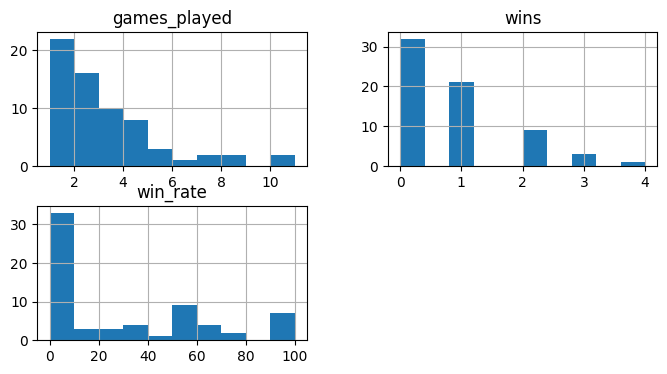

In [72]:
#visualize deck win_ratio distribution
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,4))
ax = fig.gca()
player_deck_summary.hist(ax=ax)
plt.show()

Add to player_deck_summary the Usage percentage of decks (created in deck_counts)

In [93]:
#add total matches per player column
player_deck_summary['total_matches'] = player_deck_summary.groupby('Player')['games_played'].transform('sum')

#add usage_percentage column
player_deck_summary['Usage_percentage'] = player_deck_summary['games_played'] / player_deck_summary['total_matches'] * 100

player_deck_summary.head()



,Player,Player_deck,games_played,wins,win_rate,total_matches,Usage_percentage
33,Jeroen,Prossh,1,1,100.0,53,1.886792
17,Jeroen,Adrix and nev,1,1,100.0,53,1.886792
38,Jeroen,Xyris,1,1,100.0,53,1.886792
37,Jeroen,Thrasio / vial,1,1,100.0,53,1.886792
22,Jeroen,Chatterfang,2,2,100.0,53,3.773585


### Win rate per player

In [21]:
#win rate per player
win_rate_per_player = new_magic.groupby('Player').agg(games_played=('Played','sum'),
                                                 win_ratio=('Is_winner','mean')).sort_values('win_ratio', ascending=False).reset_index()
win_rate_per_player.head()

,Player,games_played,win_ratio
0,Jeroen,53,0.490566
1,Mattijs,52,0.211538
2,Lucien,39,0.205128
3,Erwin,44,0.159091


###Win type summary

In [104]:
#win rate per player and deck
win_type_summary = new_magic.groupby(['Player', 'Wintype']).agg(games_played=('Played','sum'),
                                                 wins=('Is_winner','sum')).reset_index()

# Calculate win rate
win_type_summary['win_rate'] = win_type_summary['wins'] / win_type_summary['games_played']

win_type_summary = win_type_summary.sort_values(by=['Player', 'win_rate'], ascending=[True, False])

win_type_summary.head(10)

,Player,Wintype,games_played,wins,win_rate
1,Erwin,Last one standing,25,6,0.24
2,Erwin,Overrun,9,1,0.111111
0,Erwin,Combo,10,0,0.0
3,Jeroen,Combo,11,8,0.727273
5,Jeroen,Overrun,13,8,0.615385
4,Jeroen,Last one standing,29,10,0.344828
6,Lucien,Combo,7,2,0.285714
7,Lucien,Last one standing,25,6,0.24
8,Lucien,Overrun,7,0,0.0
10,Mattijs,Last one standing,29,7,0.241379


### How does the win type correlate to the deck and/or player?

Use One Hot Encoder on categorical features

In [99]:
from sklearn.preprocessing import OneHotEncoder

In [107]:
X= win_type_summary[['Player','Wintype']]
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(X).toarray())

enc_df.columns = enc.get_feature_names_out()

enc_df.head()

,Player_Erwin,Player_Jeroen,Player_Lucien,Player_Mattijs,Wintype_Combo,Wintype_Last one standing,Wintype_Overrun
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [110]:
win_type_summary_ohe = pd.concat([win_type_summary, enc_df], axis=1)

win_type_summary_ohe = win_type_summary_ohe.drop(columns=['Player','Wintype', 'games_played', 'wins', 'win_rate'])

win_type_summary_ohe.head()

,Player_Erwin,Player_Jeroen,Player_Lucien,Player_Mattijs,Wintype_Combo,Wintype_Last one standing,Wintype_Overrun
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Check correlation

In [111]:
win_type_summary_ohe.corr()

,Player_Erwin,Player_Jeroen,Player_Lucien,Player_Mattijs,Wintype_Combo,Wintype_Last one standing,Wintype_Overrun
Player_Erwin,1.000000e+00,-3.333333e-01,-3.333333e-01,-3.333333e-01,3.965908e-17,0.000000e+00,5.099025e-17
Player_Jeroen,-3.333333e-01,1.000000e+00,-3.333333e-01,-3.333333e-01,-5.665583e-18,-4.532467e-17,5.665583e-18
Player_Lucien,-3.333333e-01,-3.333333e-01,1.000000e+00,-3.333333e-01,-1.699675e-17,1.133117e-17,-3.965908e-17
Player_Mattijs,-3.333333e-01,-3.333333e-01,-3.333333e-01,1.000000e+00,0.000000e+00,4.532467e-17,-2.266233e-17
Wintype_Combo,3.965908e-17,-5.665583e-18,-1.699675e-17,0.000000e+00,1.000000e+00,-5.000000e-01,-5.000000e-01
Wintype_Last one standing,0.000000e+00,-4.532467e-17,1.133117e-17,4.532467e-17,-5.000000e-01,1.000000e+00,-5.000000e-01
Wintype_Overrun,5.099025e-17,5.665583e-18,-3.965908e-17,-2.266233e-17,-5.000000e-01,-5.000000e-01,1.000000e+00


***Key Takeaways:***
No Clear Preference for Win Types by Players: There’s very little correlation between any of the players and specific win types in this dataset. This suggests that players don’t strongly favor particular strategies, or their win types vary too much to show a pattern.

### How often do players change their decks

In [51]:
# Sort new_magic by Players and date
new_magic_sorted = new_magic.sort_values(by=['Player', 'Date'])

# Shift the 'Player_deck' column to compare it with the previous row (per player)
new_magic_sorted['Previous_deck'] = new_magic_sorted.groupby('Player')['Player_deck'].shift(1)

new_magic_sorted.head()

,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype,Previous_deck
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing,NaN
6,2023-06-09,474B90FE,Erwin,Atraxa,1,1,Erwin,Atraxa,Last one standing,Ikra tymna
10,2023-06-09,7F236FEB,Erwin,Meren,1,0,Jeroen,Narset,Overrun,Atraxa
14,2023-06-09,3BB54FCC,Erwin,Breya,1,1,Erwin,Breya,Last one standing,Meren
18,2023-06-17,3590F871,Erwin,Gishath,1,0,Jeroen,Abaddon,Combo,Breya


In [62]:
# Create a column to check if the deck has changed
def get_deck_change(row):
  if row['Player_deck'] != row['Previous_deck']:
    return 1
  else:
    return 0

new_magic_sorted['Deck_changed'] = new_magic_sorted.apply(get_deck_change, axis=1)

# Create a column to check if the deck was the same
def get_same_deck(row):
  if row['Player_deck'] == row['Previous_deck']:
    return 1
  else:
    return 0

new_magic_sorted['Same_deck'] = new_magic_sorted.apply(get_same_deck, axis=1)

new_magic_sorted.head()


,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype,Previous_deck,Deck_changed,Same_deck
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing,NaN,1,0
6,2023-06-09,474B90FE,Erwin,Atraxa,1,1,Erwin,Atraxa,Last one standing,Ikra tymna,1,0
10,2023-06-09,7F236FEB,Erwin,Meren,1,0,Jeroen,Narset,Overrun,Atraxa,1,0
14,2023-06-09,3BB54FCC,Erwin,Breya,1,1,Erwin,Breya,Last one standing,Meren,1,0
18,2023-06-17,3590F871,Erwin,Gishath,1,0,Jeroen,Abaddon,Combo,Breya,1,0


In [80]:
# Count the deck changes per player
deck_changes = new_magic_sorted.groupby('Player').agg({'Deck_changed':'sum',
                                                       'Same_deck':'sum',
                                                       'Played':'sum',
                                                       'Player_deck':'nunique'}).reset_index()

deck_changes

,Player,Deck_changed,Same_deck,Played,Player_deck
0,Erwin,50,3,44,16
1,Jeroen,51,2,53,23
2,Lucien,52,1,39,18
3,Mattijs,39,14,52,9


In [70]:
#Merge deck_changes to add player win ratio
deck_changes = deck_changes.merge(win_rate_per_player, on='Player')

deck_changes

,Player,Deck_changed,Same_deck,Played,Player_deck,games_played,win_ratio
0,Erwin,50,3,44,16,44,0.159091
1,Jeroen,51,2,53,23,53,0.490566
2,Lucien,52,1,39,18,39,0.205128
3,Mattijs,39,14,52,9,52,0.211538


In [71]:
#Drop games_played
deck_changes = deck_changes.drop(columns=['games_played'])
deck_changes

,Player,Deck_changed,Same_deck,Played,Player_deck,win_ratio
0,Erwin,50,3,44,16,0.159091
1,Jeroen,51,2,53,23,0.490566
2,Lucien,52,1,39,18,0.205128
3,Mattijs,39,14,52,9,0.211538


### Do players tend to repeat a deck if they're on a winning streak?

In [77]:
# Handle missing values in 'Is_winner'
new_magic_sorted['Is_winner'] = new_magic_sorted['Is_winner'].fillna(0)

# Identify Winning Streaks
def identify_streaks(df):
    streak = []
    in_streak = False
    for idx, row in df.iterrows():
        if row['Is_winner'] == 1:
            if not in_streak:
                in_streak = True
                streak_start = idx
            streak_end = idx
        else:
            if in_streak:
                in_streak = False
                streak.append((streak_start, streak_end))
    if in_streak:
        streak.append((streak_start, streak_end))

    return streak

# Apply the function
winning_streaks = identify_streaks(new_magic_sorted)

In [78]:
def check_deck_repetition(df, streaks):
    results = []
    for start, end in streaks:
        streak_df = df.iloc[start:end + 1]
        same_deck = (streak_df['Player_deck'].nunique() == 1)
        results.append({'streak_start': start, 'streak_end': end, 'same_deck': same_deck})
    return results

# Apply the function
streak_deck_repetition = check_deck_repetition(new_magic_sorted, winning_streaks)
print(streak_deck_repetition)

[{'streak_start': 6, 'streak_end': 6, 'same_deck': True}, {'streak_start': 14, 'streak_end': 14, 'same_deck': True}, {'streak_start': 42, 'streak_end': 42, 'same_deck': True}, {'streak_start': 62, 'streak_end': 62, 'same_deck': True}, {'streak_start': 102, 'streak_end': 102, 'same_deck': True}, {'streak_start': 174, 'streak_end': 174, 'same_deck': True}, {'streak_start': 210, 'streak_end': 210, 'same_deck': True}, {'streak_start': 8, 'streak_end': 8, 'same_deck': True}, {'streak_start': 16, 'streak_end': 20, 'same_deck': False}, {'streak_start': 32, 'streak_end': 36, 'same_deck': False}, {'streak_start': 48, 'streak_end': 48, 'same_deck': False}, {'streak_start': 56, 'streak_end': 56, 'same_deck': True}, {'streak_start': 64, 'streak_end': 64, 'same_deck': True}, {'streak_start': 72, 'streak_end': 84, 'same_deck': False}, {'streak_start': 92, 'streak_end': 96, 'same_deck': False}, {'streak_start': 104, 'streak_end': 104, 'same_deck': True}, {'streak_start': 120, 'streak_end': 128, 'same

In [79]:
# Create a DataFrame for correlation analysis
streak_df = pd.DataFrame(streak_deck_repetition)

# Convert boolean to integer
streak_df['same_deck'] = streak_df['same_deck'].astype(int)

# Add column for streak length
streak_df['streak_length'] = streak_df['streak_end'] - streak_df['streak_start'] + 1

# Calculate correlation
correlation = streak_df[['same_deck', 'streak_length']].corr().iloc[0, 1]
print(f'Correlation between same_deck and streak_length: {correlation}')


Correlation between same_deck and streak_length: -0.6859943405700353


In [81]:
streak_df.head()

,streak_start,streak_end,same_deck,streak_length
0,6,6,1,1
1,14,14,1,1
2,42,42,1,1
3,62,62,1,1
4,102,102,1,1


***What the Result Implies***

**As Streak Length Increases, Same Deck Usage Tends to Decrease:**

*The negative correlation suggests that for longer winning streaks, players are less likely to repeat the same deck. This means that if a player has a long winning streak, they are more likely to change decks during that streak.*

**Shorter Streaks:**

*For shorter winning streaks, there is a higher likelihood that the same deck was used throughout the streak.*

### Weighted Average Homogeneity Ratio

Do players change decks often? How homogeneous is their deck usage?

**How to Interpret the Homogeneity Ratio:**

**Low Homogeneity Ratio (closer to 0):** A player uses a wide variety of decks and frequently switches between them. A lower value indicates greater diversity in deck usage.

**High Homogeneity Ratio (further from 0):** A player tends to stick to a small number of decks and consistently uses them. A higher value shows less diversity and more consistency in deck selection.

In [41]:
# Calculate deck frequencies
deck_counts = new_magic.groupby(['Player', 'Player_deck']).size().reset_index(name='Games_with_deck')

# Calculate total matches for each player
total_matches = new_magic.groupby('Player')['Played'].sum().reset_index(name='Total_Matches')

# Merge deck counts with total matches
deck_counts = deck_counts.merge(total_matches, on='Player')
deck_counts['Usage_percentage'] = (deck_counts['Games_with_deck'] / deck_counts['Total_Matches']) * 100

deck_counts.head()

,Player,Player_deck,Games_with_deck,Total_Matches,Usage_percentage
0,Erwin,Alela,1,44,2.272727
1,Erwin,Atraxa,3,44,6.818182
2,Erwin,Breya,1,44,2.272727
3,Erwin,Calix,1,44,2.272727
4,Erwin,Edgar markov,2,44,4.545455


In [37]:
# Calculate weighted average for each player
weighted_avg = deck_counts.groupby('Player').apply(
    lambda x: (x['Usage_percentage'] * x['Games_with_deck']).sum() / x['Total_Matches'].iloc[0]
).reset_index(name='Homogeneity_Ratio')

# Display results
weighted_avg

,Player,Homogeneity_Ratio
0,Erwin,9.814050
1,Jeroen,5.802777
2,Lucien,7.429323
3,Mattijs,14.644970




> ***Results explanation***


**Player Breakdown:**

**Erwin – 9.81:**

Interpretation: *Erwin has a moderately consistent deck usage. He tends to use the same decks often, but there's some diversity in his choices. This score suggests that Erwin doesn’t switch decks as frequently as a player with a very low homogeneity ratio, but he also doesn't rely exclusively on one or two decks.*

**Jeroen – 5.80:**

Interpretation: *Jeroen has a relatively low homogeneity ratio, which indicates a more diverse deck usage. He switches between decks more often than Erwin, and his deck choices are more varied overall. Jeroen is more likely to experiment with different strategies or styles in his games.*

**Lucien – 7.43:**

Interpretation: *Lucien’s homogeneity ratio is closer to Erwin’s, indicating a moderate level of consistency in his deck usage. He uses a few decks more frequently than others, but there's still a reasonable level of diversity in his choices. Lucien likely has a preferred set of decks, but he's not overly reliant on them.*

**Mattijs – 14.64:**

Interpretation: *Mattijs has the highest homogeneity ratio, indicating that he consistently uses the same decks over a large number of games. He sticks to a smaller selection of decks more often than any other player. This suggests that Mattijs likely has a few go-to decks that he relies on regularly, with very little variation in his deck choices.*

### Simple Homogeneity Ratio

In [48]:
simple_homogeneity_ratio = deck_counts.groupby('Player').apply(
    lambda x: (x['Usage_percentage'].sum() / x['Games_with_deck'].sum())).reset_index(name='Simple_Homogeneity_Ratio')

# Display the result
simple_homogeneity_ratio


,Player,Simple_Homogeneity_Ratio
0,Erwin,2.272727
1,Jeroen,1.886792
2,Lucien,2.564103
3,Mattijs,1.923077


### Weighted AVG Homogeneity ratio correlation to win ratio

Merge win_rate_per_player with weighted_avg



In [29]:
deck_use_win = weighted_avg.merge(win_rate_per_player, on='Player')
deck_use_win

,Player,Homogeneity_Ratio,games_played,win_ratio
0,Erwin,9.814050,44,0.159091
1,Jeroen,5.802777,53,0.490566
2,Lucien,7.429323,39,0.205128
3,Mattijs,14.644970,52,0.211538


In [30]:
#Check correlation between columns
correlation_matrix = deck_use_win['Homogeneity_Ratio'].corr(deck_use_win['win_ratio'])
correlation_matrix

-0.5828280820880476

> ***Understanding the Correlation Value:***


**The correlation coefficient ranges between -1 and 1:**

**1: Perfect positive correlation –** as one variable increases, the other also increases.

**-1: Perfect negative correlation –** as one variable increases, the other decreases.

**0:** No linear relationship between the variables.

**Result: -0.5828**

Negative Correlation (-0.5828): *There is a moderate negative correlation between the Homogeneity_Ratio and the win_ratio. This means that as one increases, the other tends to decrease.*

Specifically, in this case, a **higher Homogeneity Ratio** (i.e., more consistent deck usage by a player) is associated with a **lower win ratio**.

Conversely, a lower Homogeneity Ratio (i.e., more diversity in deck usage) tends to be associated with a higher win ratio.

In [33]:
deck_use_win.columns

Index(['Player', 'Homogeneity_Ratio', 'games_played', 'win_ratio'], dtype='object')

In [35]:
#columns to use
x = deck_use_win[['Homogeneity_Ratio', 'games_played', 'win_ratio']]
y = deck_use_win['Player']

#check total table correlation
x.corr()

,Homogeneity_Ratio,games_played,win_ratio
Homogeneity_Ratio,1.000000,0.248175,-0.582828
games_played,0.248175,1.000000,0.621313
win_ratio,-0.582828,0.621313,1.000000


> Results insights

**1. Correlation Between Homogeneity_Ratio and games_played: 0.2482**
Interpretation: *There is a weak positive correlation between the number of games played and the homogeneity ratio.
A value of 0.2482 suggests that as a player plays more games, their deck usage becomes slightly more consistent, but this relationship is weak. It indicates that players who participate in more games tend to use the same decks more often, though it's not a strong effect.*

**2. Correlation Between Homogeneity_Ratio and win_ratio: -0.5828**
Interpretation: *See above.*

**3. Correlation Between games_played and win_ratio: 0.6213**
Interpretation: *There is a moderate positive correlation between the number of games played and the win ratio.
A value of 0.6213 suggests that players who play more games tend to have a higher win ratio. This could indicate that more experienced players, who participate in a greater number of games, are more successful overall.*

### Weighted Average Percentage of Uniqueness

In [50]:
deck_counts['Uniqueness'] = 1 / (deck_counts['Usage_percentage'] / 100)

# create weighted_avg_uniqueness
weighted_avg_uniqueness = deck_counts.groupby('Player').apply(
    lambda x: (x['Uniqueness'] * x['Count']).sum() / x['Total_Matches'].iloc[0]
).reset_index(name='Weighted_Average_Uniqueness')

weighted_avg_uniqueness

,Player,Weighted_Average_Uniqueness
0,Erwin,16.0
1,Jeroen,23.0
2,Lucien,18.0
3,Mattijs,9.0


###Players matchups

In [87]:
# Filter rows where Player is not the Match_winner (opponents)
opponents_df = new_magic[new_magic['Player'] != new_magic['Match_winner']]

# Group by Match_winner, Winning_deck, Player (opponent), and Player_deck (opponent deck) to count occurrences
players_matchup = opponents_df.groupby(['Match_winner', 'Winning_deck', 'Player', 'Player_deck']).size().reset_index(name='count')

players_matchup = players_matchup[players_matchup['Match_winner'] != 'Unkown']

players_matchup.head()

,Match_winner,Winning_deck,Player,Player_deck,count
0,Erwin,Atraxa,Jeroen,Krav regna,1
1,Erwin,Atraxa,Lucien,"Sheodred, the apocalypse",1
2,Erwin,Atraxa,Mattijs,Animar,1
3,Erwin,Breya,Jeroen,"Omnath, locus of rage",1
4,Erwin,Breya,Lucien,"Sheodred, the apocalypse",1


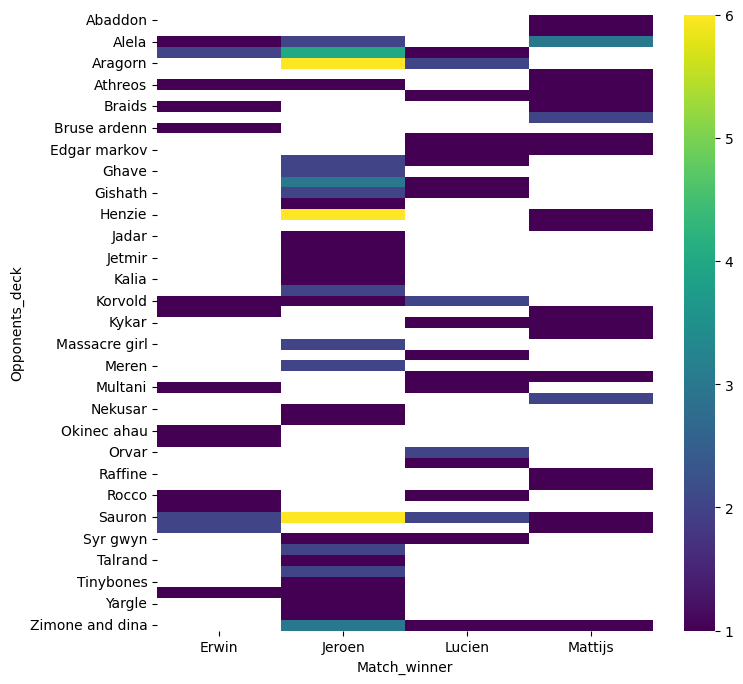

In [134]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Player_deck'].value_counts()
    for x_label, grp in players_matchup.groupby('Match_winner')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Match_winner')
_ = plt.ylabel('Opponents_deck')

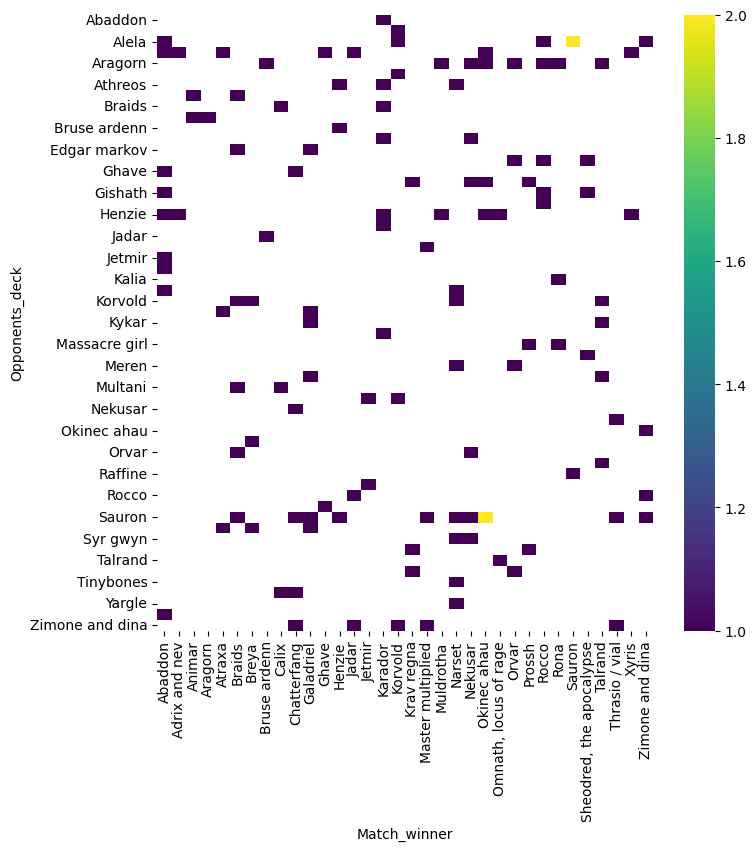

In [112]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Player_deck'].value_counts()
    for x_label, grp in players_matchup.groupby('Winning_deck')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Match_winner')
_ = plt.ylabel('Opponents_deck')

# Relevant tables

### New magic

Has one row per match, with date information and players listed in one single column.

In [82]:
new_magic

,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype
0,2023-06-09,9418966F,Jeroen,Bruse tymna,1,0,Mattijs,Karador,Last one standing
1,2023-06-09,9418966F,Mattijs,Karador,1,1,Mattijs,Karador,Last one standing
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing
3,2023-06-09,9418966F,Lucien,Athreos,1,0,Mattijs,Karador,Last one standing
4,2023-06-09,474B90FE,Jeroen,Krav regna,1,0,Erwin,Atraxa,Last one standing
...,...,...,...,...,...,...,...,...,...
207,2024-08-04,4F125A56,Lucien,NaN,0,<NA>,Mattijs,Animar,Last one standing
208,2024-08-04,A70CE784,Jeroen,Okinec ahau,1,0,Erwin,Zimone and dina,Last one standing
209,2024-08-04,A70CE784,Mattijs,Sauron,1,0,Erwin,Zimone and dina,Last one standing
210,2024-08-04,A70CE784,Erwin,Zimone and dina,1,1,Erwin,Zimone and dina,Last one standing


### New_magic_sorted

No dates. One row per match, ordered per Player/Deck. Also has info on wheter decks have been re-used or not. Can be used to find correlation between wins and deck repetition

In [83]:
new_magic_sorted

,Date,Game_id,Player,Player_deck,Played,Is_winner,Match_winner,Winning_deck,Wintype,Previous_deck,Deck_changed,Same_deck
2,2023-06-09,9418966F,Erwin,Ikra tymna,1,0,Mattijs,Karador,Last one standing,NaN,1,0
6,2023-06-09,474B90FE,Erwin,Atraxa,1,1,Erwin,Atraxa,Last one standing,Ikra tymna,1,0
10,2023-06-09,7F236FEB,Erwin,Meren,1,0,Jeroen,Narset,Overrun,Atraxa,1,0
14,2023-06-09,3BB54FCC,Erwin,Breya,1,1,Erwin,Breya,Last one standing,Meren,1,0
18,2023-06-17,3590F871,Erwin,Gishath,1,0,Jeroen,Abaddon,Combo,Breya,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
193,2024-07-20,5BC0B46E,Mattijs,Karador,1,1,Mattijs,Karador,Last one standing,Korvold,1,0
197,2024-08-04,E829127E,Mattijs,Animar,1,0,Jeroen,Xyris,Combo,Karador,1,0
201,2024-08-04,02B2BA16,Mattijs,Animar,1,0,Jeroen,Adrix and nev,Combo,Animar,0,1
205,2024-08-04,4F125A56,Mattijs,Animar,1,1,Mattijs,Animar,Last one standing,Animar,0,1


### Decks

How often were decks used overall

In [84]:
deck_counts

,Player,Player_deck,Games_with_deck,Total_Matches,Usage_percentage
0,Erwin,Alela,1,44,2.272727
1,Erwin,Atraxa,3,44,6.818182
2,Erwin,Breya,1,44,2.272727
3,Erwin,Calix,1,44,2.272727
4,Erwin,Edgar markov,2,44,4.545455
...,...,...,...,...,...
61,Mattijs,Karador,5,52,9.615385
62,Mattijs,Korvold,7,52,13.461538
63,Mattijs,Sauron,11,52,21.153846
64,Mattijs,Syr konrad,2,52,3.846154


In [94]:
player_deck_summary

,Player,Player_deck,games_played,wins,win_rate,total_matches,Usage_percentage
33,Jeroen,Prossh,1,1,100.0,53,1.886792
17,Jeroen,Adrix and nev,1,1,100.0,53,1.886792
38,Jeroen,Xyris,1,1,100.0,53,1.886792
37,Jeroen,Thrasio / vial,1,1,100.0,53,1.886792
22,Jeroen,Chatterfang,2,2,100.0,53,3.773585
...,...,...,...,...,...,...,...
32,Jeroen,Prismatic bridge,1,0,0.0,53,1.886792
34,Jeroen,Raffine,1,0,0.0,53,1.886792
39,Lucien,Aclazotz,1,0,0.0,39,2.564103
40,Lucien,Alela,5,0,0.0,39,12.820513


Contains Weighted Average Homogeneity Ratio

In [85]:
deck_use_win

,Player,Homogeneity_Ratio,games_played,win_ratio
0,Erwin,9.814050,44,0.159091
1,Jeroen,5.802777,53,0.490566
2,Lucien,7.429323,39,0.205128
3,Mattijs,14.644970,52,0.211538


### Players matchup

In [88]:
players_matchup

,Match_winner,Winning_deck,Player,Player_deck,count
0,Erwin,Atraxa,Jeroen,Krav regna,1
1,Erwin,Atraxa,Lucien,"Sheodred, the apocalypse",1
2,Erwin,Atraxa,Mattijs,Animar,1
3,Erwin,Breya,Jeroen,"Omnath, locus of rage",1
4,Erwin,Breya,Lucien,"Sheodred, the apocalypse",1
...,...,...,...,...,...
124,Mattijs,Korvold,Lucien,Aclazotz,1
125,Mattijs,Korvold,Lucien,Alela,1
126,Mattijs,Sauron,Erwin,Alela,1
127,Mattijs,Sauron,Jeroen,Raffine,1


# Export datasets

In [95]:
from google.colab import auth
from google.auth import default

try:
  import gspread
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install gspread
  import gspread

from gspread_dataframe import set_with_dataframe

In [96]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

Export new_magic to tab 1

In [140]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(0)

# Create a DataFrame from the keywords_metrics DataFrame
df = new_magic

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)

Export players_matchup to tab 2

In [141]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(1)

# Create a DataFrame from the keywords_metrics DataFrame
df = players_matchup

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)

Export win_type_summary to tab 3

In [142]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(2)

# Create a DataFrame from the keywords_metrics DataFrame
df = win_type_summary

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)

Export player_deck_summary

In [97]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(3)

# Create a DataFrame from the keywords_metrics DataFrame
df = player_deck_summary

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)

Export deck_use_win to tab 5

In [113]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(4)

# Create a DataFrame from the keywords_metrics DataFrame
df = deck_use_win

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)


Export new_magic_sorted to tab 6

In [114]:
# Open an existing Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1kmrvcxpWj7HqtUjkX-yYED6yRB04PT_mS1VGbvUmAdQ/edit?usp=sharing'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first sheet or create a new one
worksheet = spreadsheet.get_worksheet(5)

# Create a DataFrame from the keywords_metrics DataFrame
df = new_magic_sorted

# Write the DataFrame to the worksheet
set_with_dataframe(worksheet, df)